In [32]:
!pip install pandas
!pip install geopandas
!pip install lxml
!pip install urllib
!pip install matplotlib
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
!pip install mapclassify

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to c:\users\auran\appdata\local\temp\pip-req-build-yu24yqi2
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette 'C:\Users\auran\AppData\Local\Temp\pip-req-build-yu24yqi2'
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a


     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------------- -------------------- 0.8/1.6 MB 50.6 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 26.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ----------- ---------------------------- 2.8/9.3 MB 58.8 MB/s eta 0:00:01
   ------------------------ --------------- 5.6/9.3 MB 59.4 MB/s eta 0:00:01
   -------------------------------- ------- 7.6/9.3 MB 60.5 MB/s eta 0:00:01
   --------------------------------- ------ 7.8/9.3 MB 45.4 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 42.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.1 MB ? eta -:--:--
   - -------------------------------------- 2.2/44.1 MB 68.2 MB/s eta 0:00:01
   ---- ---------------

In [33]:
import importlib
import pandas as pd
import requests
import geopandas as gpd
from os.path import isfile
import declarations as dec
import matplotlib
import mapclassify

### Téléchargement des données de consommation d'électricité annuelle par adresse

In [2]:
def get_data_consumption(url, year, replace:bool = False):
    '''Gets the data of home's electricity consumption
    Args:
        url(string)
        year(string)
        replace(bool): True to replace consommation{year}.csv if it exists. Defaults to False.
    Returns:
        df (dataframe): dataframe of the home's electricity consumption for the wanted year 
    '''
    path_to_data="consommation"+f"{year}"+".csv"
    if (isfile(path_to_data) and not replace):
        df=pd.read_csv(path_to_data, sep=";")
    else:
        print("Chargement des données, cette étape peut prendre quelques minutes")
        response=requests.get(url)
        if response.status_code == 200:
            with open(path_to_data, "wb") as file:
                file.write(response.content)
            print("Téléchargement réussi.")
        else:
            print(f"Échec du téléchargement. Code d'état : {response.status_code}")
        df=pd.read_csv(path_to_data, sep=";")
    return df


In [48]:
# URL des bases de données à charger 

consumption_data_url_2018="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222018%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2019= "https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222019%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2020="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222020%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
consumption_data_url_2021="https://enedis.opendatasoft.com/api/explore/v2.1/catalog/datasets/consommation-annuelle-residentielle-par-adresse/exports/csv?lang=fr&refine=annee%3A%222021%22&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"

In [49]:
df_cons_2018=get_data_consumption(consumption_data_url_2018, "2018")
df_cons_2019=get_data_consumption(consumption_data_url_2019, "2019")
df_cons_2020=get_data_consumption(consumption_data_url_2020, "2020")
df_cons_2021=get_data_consumption(consumption_data_url_2021, "2021")

C:\Users\auran\AppData\Local\Temp\ipykernel_11988\3130095385.py:12: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path_to_data, sep=";")
C:\Users\auran\AppData\Local\Temp\ipykernel_11988\3130095385.py:12: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path_to_data, sep=";")


### Récupération des données de Diagnostics de Performance Energétique (DPE)

In [3]:
def get_dpe_from_url(api_url):
    '''Imports a database from an API url.
    Args:
        api_url (string) : url of the wanted API
    Returns:
        pandas.DataFrame : dataframe
    '''
    req=requests.get(api_url)
    wb=req.json()
    df = pd.json_normalize(wb["results"])
    dpe = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 4326)
    dpe = dpe.dropna(subset = ['longitude', 'latitude'])
    return dpe

In [51]:
# Il est trop couteux de récupérer l'intégralité des données et nous ne disposons de données météo que pour
# certaines communes. L'idée est donc de ne récupérer les données de DPE que pour les communes voulues et de
# les agréger dans une unique table de données.

def get_dpe_dataset(api_root, communes):
    '''
    Args : 
    Returns : 
    '''


### Récupération des données de consommation annuelle d'électricité et gaz par département et par secteur d'activité

In [4]:
def get_data_consumption_department(df, year):
    '''Gets the data of the annual electricity consumption per "département" for a specific year
    Args:
        df (DataFrame)
        year(string)
    Returns:
        df (dataframe): dataframe of the home's electricity consumption for the wanted year 
    '''
    df_year= df[(df["Année"]==year) & (df["Filière"]=="Electricité")]
    return df_year


In [5]:
# Base de données 
cons_département="https://opendata.agenceore.fr/api/explore/v2.1/catalog/datasets/conso-elec-gaz-annuelle-par-secteur-dactivite-agregee-departement/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
df_cons_département=pd.read_csv(cons_département, sep=";")


In [6]:
variables_cons_département= ['Opérateur', 'Année', 'Filière', 
                             'Consommation Résidentiel  (MWh)', 'Nombre de points Résidentiel', 
                             'Nombre de mailles secretisées (résidentiel)','Indice qualité Résidentiel',
                             'Code Département', 'Libellé Département','Code Région', 'Libellé Région', 
                             'id_filiere','Consommation totale (MWh)']
liste_département=pd.unique(df_cons_département["Libellé Département"])


In [20]:
list_années=pd.unique(df_cons_département["Année"])
dico_cons_département={} # Création d'un dictionnaire qui à chaque année associe le dataframe de consommation d'électricité résidentielle par départements
dico_cons_tot={}
for année in list_années:
    if année not in dico_cons_département:
        df_année=get_data_consumption_department(df_cons_département, année)
        dico_cons_département[année]=dec.df_filter(df_année, variables_cons_département) # On sélectionne les variables dont on a besoin
        df_cons_tot=dico_cons_département[année].groupby(["Code Département","Libellé Département"])['Consommation Résidentiel  (MWh)'].sum().reset_index()
        df_cons_tot=pd.merge(df_cons_tot, dec.df_filter(dec.dep, dec.var_dep), how='left', left_on='Code Département', right_on='INSEE_DEP')
        df_cons_tot=gpd.GeoDataFrame(df_cons_tot, crs='EPSG:4326', geometry=df_cons_tot['geometry'])
        dico_cons_tot[année]=df_cons_tot


C:\Users\auran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


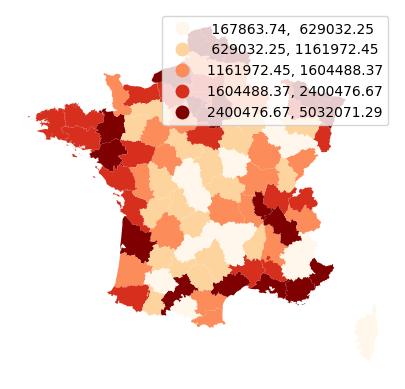

In [40]:
#dico_cons_tot[2011].head()
ax = dico_cons_tot[2018].plot(column = "Consommation Résidentiel  (MWh)", 
                              legend=True,
                              #legend_kwds={"label": "Consommation Résidentiel (MWh)"},
                              cmap='OrRd',
                              scheme='quantiles')

ax.set_axis_off();